autism image classification with witha  weighted loss for the cars score: people with severe autism will be treated more importantly in our model

In [1]:
import cv2
import os
import json
import gc

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import KFold
from PIL import Image
import numpy as np

from sklearn.decomposition import PCA
from tensorflow.keras.regularizers import l2

from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.metrics import precision_score, recall_score,  f1_score
from sklearn.model_selection import cross_val_predict

from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications import EfficientNetV2B0

In [2]:
metadata_path = "../dataset/Metadata/data.json"
image_dir = "../dataset/Images/"
input_shape=(224,224)
batch_size=16

In [3]:
def open_image(image_path):
        # Load the image using Pillow
    pil_img = Image.open(image_path).convert("RGB")  # Convert to RGB (if not already)
    img_array = np.array(pil_img)
    return img_array

def show_image(img_array):
    if(img_array.shape[2]== 1):
        plt.imshow(img_array.astype('uint8'), cmap='gray')
    else:
        plt.imshow(img_array)
    plt.axis('off')
    plt.show()

In [4]:
def get_data_labels_and_metadata(dataset):
    """
    Extracts data and labels from a TensorFlow dataset.

    Args:
        dataset (tf.data.Dataset): The dataset to extract data and labels from.

    Returns:
        Tuple of (data, labels), where:
        - data is a NumPy array of features.
        - labels is a NumPy array of labels.
    """
    data = []
    labels = []
    metadatas=[]
    dataset = dataset.unbatch()

    for features, label, metadata in dataset:
        data.append(features.numpy())
        labels.append(label.numpy())
        metadatas.append(metadata.numpy())

    # Convert lists to NumPy arrays
    data = np.array(data)
    labels = np.array(labels)
    metadata = np.array(metadatas)

    return data, labels, metadata


In [5]:
def create_dataset(data, labels, metadata, batch_size=batch_size, shuffle=True):
    """
    Create a tf.data.Dataset from images and labels.

    Args:
        data (list or np.array): List or array of image data.
        labels (list or np.array): Corresponding labels.
        batch_size (int): Batch size for the dataset.
        shuffle (bool): Whether to shuffle the dataset.

    Returns:
        tf.data.Dataset: A TensorFlow dataset.
    """

    dataset = tf.data.Dataset.from_tensor_slices((data, labels, metadata))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(data))
    dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

In [6]:
# One hot encoding
class_mapping = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(["TC", "TS"]),
        values=tf.constant([0, 1])  # Map to integers
    ),
    default_value=-1  # Handle unknown values
)

def one_hot_encode(data, label, metadata):
    num_classes = 2  # Adjust this to the actual number of classes
    # Map string labels to integers

    label = class_mapping.lookup(label)
    # Check for unmapped (invalid) labels
    tf.debugging.assert_greater_equal(label, 0, message="Unknown label encountered")

    label = tf.squeeze(label)
    label = tf.one_hot(label, depth=num_classes)

    return data, label, metadata

In [7]:
def load_metadata_json(metadata_path):
    """
    Load metadata from a JSON file.
    Args:
        metadata_path (str): Path to the metadata file (JSON format).
    Returns:
        list: A list of dictionaries with metadata.
    """
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    return metadata


def match_metadata_with_images_json(image_dir, metadata, target_size=(100, 100)):
    """
    Match images with their metadata and preprocess the data.
    Args:
        image_dir (str): Path to the directory containing images.
        metadata (dict): Metadata grouped by 'TCImages' and 'TSImages'.
        target_size (tuple): Target size for image resizing.
    Returns:
        np.array, np.array, np.array: Preprocessed images, labels, and metadata features.
    """
    data = []
    labels = []
    metadata_features = []

    # Merge metadata entries from both TCImages and TSImages
    metadata_merged = metadata['TCImages'] + metadata['TSImages']

    for entry in metadata_merged:
        # Extract filename, label, and metadata features
        filename = entry['File']
        # participant_id = entry['ParticipantID']
        # age = float(entry['Age']) if 'Age' in entry and entry['Age'] else np.nan
        # gender = entry['Gender'] if 'Gender' in entry else None
        cars_score = entry['CARS']

        # if(image_dir.find("Unseen")):
        #     if(math.isnan(cars_score)):
        #         label= 

        # # Determine the label
        # if(cars_score==0):
        #     label = "TC"
        # else: 
        #     label = "TS"

        subdir=''
        # Determine the image path
        if "TC" in filename:
            subdir = 'TCImages'
            label='TC'
        elif "TS" in filename:
            subdir = 'TSImages'
            label='TS'
            
        image_path = os.path.join(image_dir, subdir, filename)

        # Preprocess the image if it exists

        if os.path.exists(image_path):

            img_array = open_image(image_path)
            data.append(img_array)

            # Collect label and metadata features
            labels.append(label)
            metadata_features.append(
                #'CARS':
                cars_score
                # 'ParticipantID': participant_id,
                # 'Age': age,
                # 'Gender': gender,
            )
        else:
            print(f"Warning: Image {filename} not found! {image_path}")

    labels = np.array(labels)

    # Convert metadata features to structured NumPy array
    # Encode categorical features (e.g., Gender)
    # metadata_features_array = np.array([

    #         feature['CARS']
    #         # float(feature['ParticipantID']),
    #         # feature['Age'],
    #         # hash(feature['Gender']) if feature['Gender'] is not None else 0

    #     #for feature in metadata_features
    # ]).astype('float32')

    metadata_features_array = np.array(metadata_features)

    metadata_features_array = np.nan_to_num(metadata_features_array, nan=0.0)

    return data, labels, metadata_features_array


In [8]:
def average_laplacian(image):
    """Applies an average filter followed by a Laplacian filter."""
    kernel_size = (3, 3)  # Define kernel size for averaging
    average_filtered = cv2.blur(image, kernel_size)

    # Convert image to float64 for Laplacian
    image = image.astype(np.float64)  # Use np.float64 for the Laplacian filter

    # Apply the Laplacian filter
    laplacian_filtered = cv2.Laplacian(image, cv2.CV_64F)

    # Enhance the image
    enhanced_image = laplacian_filtered - average_filtered

    # Convert back to uint8 (clip to valid range)
    enhanced_image = np.clip(enhanced_image, 0, 255).astype(np.uint8)

    return enhanced_image


In [9]:
def preprocess_image(img_array,color, target_size):
    """
    Preprocess a batch of images:
    - Convert each image in the batch to grayscale.
    - Resize each image to the target size.
    Args:
        img_array (np.array): Input batch of images (batch_size, H, W, C).
        target_size (tuple): Desired target size (width, height).
    Returns:
        np.array: Preprocessed grayscale images of target size (batch_size, H', W').
    """
    if img_array is None or img_array.size == 0:
        raise ValueError("Input image array is empty or None.")

    # Ensure the input image has the correct shape
    if img_array.ndim == 3 and img_array.shape[-1] == 1:
        img_array = img_array.squeeze(-1)  # Remove the single channel -> (H, W)

    #laplacian_img = average_laplacian(img_array)  # Apply Laplacian filter

    laplacian_img =cv2.threshold(img_array, 4, 255, cv2.THRESH_BINARY)[1]

    if color is False:
        #grayscale_img = cv2.threshold(laplacian_img, 0, 255, cv2.THRESH_BINARY)[1]
        grayscale_img = cv2.cvtColor(laplacian_img, cv2.COLOR_RGB2GRAY)  # Already grayscale
        grayscale_img = cv2.equalizeHist(grayscale_img)  # Histogram equalization
        resized_img = cv2.resize(grayscale_img, target_size, interpolation=cv2.INTER_AREA)
        resized_img = np.expand_dims(resized_img, axis=-1)
    else:
      grayscale_img = laplacian_img
      resized_img = cv2.resize(grayscale_img, target_size, interpolation=cv2.INTER_AREA)


    return resized_img

def preprocess_dataset(concat_data, concat_labels, target_size, color):
    """
    Processes a MapDataset and prepares the dataset.
    Assumes the dataset yields tuples of (image, label).
    """
    data = []
    labels = []

    for img_array, label in zip(concat_data, concat_labels):
        processed_image = preprocess_image(img_array, color, target_size)
        data.append(processed_image)
        labels.append(label)

    # Add a channel dimension for grayscale images (required for CNN input)
    # if color==False:
    #     data = np.expand_dims(data, axis=-1)

    data = np.array(data)
    labels = np.array(labels)

    #processed_dataset = tf.data.Dataset.from_tensor_slices((data, labels))
    return data, labels


In [10]:
def save_dataset(dataset, dataset_name):
    # Initialize lists to store dataset elements (features, labels)
    features_list = []
    labels_list = []
    metadata_list = []

    # Iterate through the dataset and collect the elements
    for features, labels, metadata in dataset:
        features_list.append(features.numpy())  # Convert tensors to NumPy
        labels_list.append(labels.numpy())
        metadata_list.append(metadata.numpy())

    # Save as .npy files
    np.save(f"{dataset_name}_features.npy", np.array(features_list))
    np.save(f"{dataset_name}_labels.npy", np.array(labels_list))
    np.save(f"{dataset_name}_metadata.npy", np.array(metadata_list))
    print(f"Dataset saved as {dataset_name}_features.npy and {dataset_name}_labels.npy")

def load_dataset(dataset_name):
    # Load the saved NumPy arrays
    features = np.load(f"{dataset_name}_features.npy",allow_pickle=True)
    labels = np.load(f"{dataset_name}_labels.npy",allow_pickle=True)
    metadata = np.load(f"{dataset_name}_metadata.npy",allow_pickle=True)

    # Convert them back to TensorFlow tensors
    features_tensor = tf.convert_to_tensor(features)
    labels_tensor = tf.convert_to_tensor(labels)
    metadata_tensor = tf.convert_to_tensor(metadata)

    # Create a TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((features_tensor, labels_tensor, metadata_tensor))
    return dataset

In [11]:
# Load the metadata
metadata_list = load_metadata_json(metadata_path)

# Preprocess data and metadata
data, labels, metadata_features = match_metadata_with_images_json(image_dir, metadata_list)

In [12]:
metadata_features.mean()

12.126142595978061

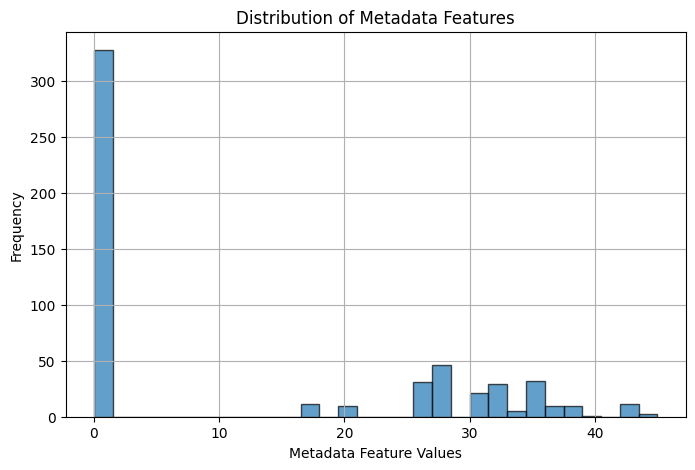

In [13]:
plt.figure(figsize=(8, 5))
plt.hist(metadata_features, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Metadata Feature Values")
plt.ylabel("Frequency")
plt.title("Distribution of Metadata Features")
plt.grid(True)
plt.show()

In [14]:
data, labels = preprocess_dataset(data, labels, target_size=input_shape, color=True)

In [15]:
# Define Data Augmentation Pipeline
# data_augmentation = tf.keras.Sequential([
#     layers.RandomFlip("horizontal_and_vertical"),
#     layers.RandomRotation(0.5, interpolation="nearest"),
#     layers.RandomZoom(0.2),
#     layers.RandomTranslation(0.2,0.2)
#     #layers.RandomBrightness(0.1),
# ])
import albumentations as A
from albumentations.pytorch import ToTensorV2

albumentations_augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),  
    A.VerticalFlip(p=0.5),  
    A.Rotate(limit=30, interpolation=1, border_mode=0, p=0.5),  
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.5),  
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),  
    A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),  
    A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.5),  
    A.Normalize(mean=[0.5], std=[0.5]),  # For grayscale masks, use mean & std of [0.5]
    ToTensorV2()
])

def albumentations_augment(image):
    """
    Applies Albumentations transformations to a single image.
    Expects image as a NumPy array.
    """
    augmented = albumentations_augmentation(image=image)
    return augmented["image"]

def augment_multiple_times(data, labels, metadata_features, augmentations=5, batch_size=32):
    """
    Augment images multiple times using Albumentations while keeping metadata aligned.

    Args:
        data (tf.Tensor): Input tensor of images.
        labels (tf.Tensor): Corresponding labels.
        metadata_features (np.array or tf.Tensor): Metadata for each image.
        augmentations (int): Number of augmentations to apply.
        batch_size (int): Number of images to process per batch.

    Returns:
        augmented_images (tf.Tensor): Augmented images.
        augmented_labels (tf.Tensor): Augmented labels.
        augmented_metadata (tf.Tensor): Augmented metadata.
    """
    augmented_images = []
    augmented_labels = []
    augmented_metadata = []

    for i in range(0, data.shape[0], batch_size):
        batch_data = data[i:i+batch_size]  # Convert to NumPy
        batch_labels = labels[i:i+batch_size]
        batch_metadata = metadata_features[i:i+batch_size]

        for _ in range(augmentations):
            batch_augmented = np.array([albumentations_augment(img) for img in batch_data])

            batch_augmented = ((batch_augmented + 1) * 127.5)

            # Convert back to TensorFlow tensor
            augmented_images.append(tf.convert_to_tensor(batch_augmented, dtype=tf.float16))
            augmented_labels.append(batch_labels)
            augmented_metadata.append(batch_metadata)

    # Concatenate augmented batches
    augmented_images = tf.concat(augmented_images, axis=0)
    augmented_labels = tf.concat(augmented_labels, axis=0)
    augmented_metadata = tf.concat(augmented_metadata, axis=0)

    return augmented_images, augmented_labels, augmented_metadata



# def augment_multiple_times(data, labels, metadata_features, augmentations=5, batch_size=32):
#     """
#     Augment images multiple times while keeping metadata aligned.

#     Args:
#         data (tf.Tensor): Input tensor of images.
#         labels (tf.Tensor): Corresponding labels.
#         metadata_features (np.array or tf.Tensor): Metadata for each image.
#         augmentations (int): Number of augmentations to apply.
#         batch_size (int): Number of images to process per batch.

#     Returns:
#         augmented_images (tf.Tensor): Augmented images.
#         augmented_labels (tf.Tensor): Augmented labels.
#         augmented_metadata (tf.Tensor): Augmented metadata.
#     """
#     augmented_images = []
#     augmented_labels = []
#     augmented_metadata = []

#     for i in range(0, data.shape[0], batch_size):

#         # Get current batch
#         batch_data = data[i:i+batch_size]
#         #batch_data = tf.squeeze(batch_data, axis=-1)  # Remove the last channel
#         batch_labels = labels[i:i+batch_size]
#         batch_metadata = metadata_features[i:i+batch_size]

#         # Augment the current batch
#         for _ in range(augmentations):
#             augmented_images.append(data_augmentation(batch_data))
#             augmented_labels.append(batch_labels)
#             augmented_metadata.append(batch_metadata)  # Duplicate metadata for each augmentation

#     # Convert to tensors
#     augmented_images = tf.concat(augmented_images, axis=0)
#     augmented_labels = tf.concat(augmented_labels, axis=0)
#     augmented_metadata = tf.concat(augmented_metadata, axis=0)

#     return augmented_images, augmented_labels, augmented_metadata


c:\Users\Alex\miniconda3\envs\asdlicenta\lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.0'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
c:\Users\Alex\miniconda3\envs\asdlicenta\lib\site-packages\albumentations\core\validation.py:45: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\Alex\AppData\Local\Temp\ipykernel_1968\4231825003.py:17: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),
C:\Users\Alex\AppData\Local\Temp\ipykernel_1968\4231825003.py:19: UserWarning: Argument 'max_holes' is not valid and will be ignored.
  A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.5),
C:\Users\A

In [16]:
with tf.device('/CPU:0'):
    augmented_data, augmented_labels, augmented_metadata = augment_multiple_times(data, labels, metadata_features, augmentations=17, batch_size=batch_size)

In [17]:
# Instead of combining original and augmented images:
# combined_data = augmented_data
# combined_labels = augmented_labels
# combined_metadata = augmented_metadata

In [18]:
with tf.device('/CPU:0'):
    augmented_data = tf.transpose(augmented_data, [0, 2, 3, 1])

In [19]:
combined_data = np.concatenate((data, augmented_data), axis=0)
combined_labels = np.concatenate((labels, augmented_labels), axis=0)
combined_metadata = np.concatenate((metadata_features, augmented_metadata), axis=0)

In [20]:
#with tf.device('/CPU:0'):
#pre_pca_combined = create_dataset(combined_data, combined_labels, combined_metadata)

In [21]:
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# Example Tensor of string labels
tensor_data = tf.constant(combined_labels, dtype=tf.string)

# Convert the tensor to a list of strings
strings = tensor_data.numpy().astype(str)

# Reshape the data to match the expected input shape for OneHotEncoder
strings_reshaped = np.array(strings).reshape(-1, 1)

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit and transform the data
combined_labels = encoder.fit_transform(strings_reshaped)


In [22]:
# with tf.device('/CPU:0'):
#     save_dataset(pre_pca_combined, "autism2_dataset")

In [23]:
#pre_pca_combined= load_dataset("autism2_dataset")

In [24]:
gc.collect()

20

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..254.0].


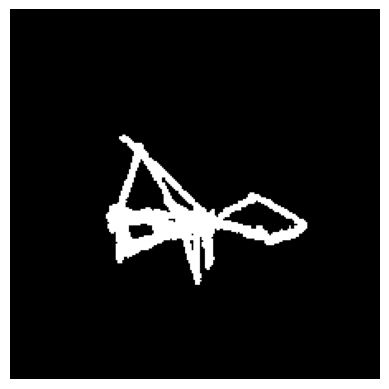

In [25]:
with tf.device('/CPU:0'):
    show_image(combined_data[1000].astype(np.float32))

In [26]:
# combined_data = combined_data.numpy()  # Convert to numpy array
# combined_labels = combined_labels.numpy()  # Convert to numpy array
# combined_metadata = combined_metadata.numpy()  # Convert to numpy array

In [27]:
from sklearn.model_selection import train_test_split

with tf.device('/CPU:0'):
    train_data, test_data, train_labels, test_labels, train_metadata, test_metadata = train_test_split(
        combined_data, 
        combined_labels, 
        combined_metadata, 
        test_size=0.2,  # Adjust the test size as needed (e.g., 20% test data)
        random_state=42,

    )

    train_data, validation_data, train_labels, validation_labels, train_metadata, validation_metadata = train_test_split(
        train_data, 
        train_labels, 
        train_metadata, 
        test_size=0.2,  # Adjust the test size as needed (e.g., 20% test data)
        random_state=42,  # Optional: For reproducibility
    )

In [28]:
max_cars_score = 60
train_metadata = tf.cast(train_metadata, dtype=tf.float32) / max_cars_score  # Normalize to [0, 1]

train_metadata = tf.constant(1, dtype=float) + train_metadata
# for i in range(len(train_metadata)):
#     train_metadata[i] = 1.0 + train_metadata[i]  # Rescale to [1, 2]

<h2> pre </h2>

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Concatenate)
from tensorflow.keras.regularizers import l2

def feature_extractor_cnn(input_shapes):
    image_input_shape = input_shapes
    
    # Image input branch
    image_input = Input(shape=image_input_shape)
    x = Conv2D(filters=16, kernel_size=(5, 5), activation='relu', padding='same')(image_input)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(filters=32, kernel_size=(5, 5), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(filters=128, kernel_size=(5, 5), activation='relu', padding='same')(x)
    #x = Dropout(rate=0.3)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = GlobalAveragePooling2D()(x)
    #x = Dropout(0.3)(x)
    
    model = Model(inputs=image_input, outputs=x)
    
    return model


In [2]:
input_shape = (224, 224, 3)
cnn_feature_extractor = feature_extractor_cnn(input_shape)

NameError: name 'GlobalAveragePooling2D' is not defined

In [ ]:
def create_model_cnn(feature_extractor):

    image_input = feature_extractor.input
    feature_output = feature_extractor.output


    x = Dense(128, activation='relu')(feature_output)
    x = Dropout(0.3)(x)  # Add dropout to prevent overfitting
    x = Dense(64, activation='relu')(x)
    x = Dense(2, activation='softmax')(x)


    model = Model(inputs=image_input, outputs=x)
    
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=categorical_focal_loss(),
                  metrics=['accuracy'])
    
    return model


In [ ]:
model_cnn = create_model_cnn(cnn_feature_extractor)

# 3. Compile the model
model_cnn.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 224, 224, 16)      416       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 112, 112, 32)      12832     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 56, 56, 128)       102

In [ ]:
reset_weights(model_cnn)

In [ ]:
history_cnn = model_cnn.fit(train_data, train_labels, batch_size=batch_size, epochs=20, 
                            validation_data=(validation_data, validation_labels),
                            sample_weight=train_metadata,
                            callbacks=[early_stopping])

Epoch 1/20
241/241 [==============================] - 7s 25ms/step - loss: 0.0226 - accuracy: 0.4013 - val_loss: 0.8844 - val_accuracy: 0.4123
Epoch 2/20
241/241 [==============================] - 6s 24ms/step - loss: 5.5535e-04 - accuracy: 0.3984 - val_loss: 1.0838 - val_accuracy: 0.4123
Epoch 3/20
241/241 [==============================] - 6s 23ms/step - loss: 2.2259e-04 - accuracy: 0.3984 - val_loss: 1.1873 - val_accuracy: 0.4123
Epoch 4/20
241/241 [==============================] - 6s 24ms/step - loss: 1.6685e-04 - accuracy: 0.3984 - val_loss: 1.3095 - val_accuracy: 0.4123
Epoch 5/20
241/241 [==============================] - 6s 24ms/step - loss: 1.0793e-04 - accuracy: 0.3984 - val_loss: 1.4188 - val_accuracy: 0.4123


<h2>effective</h2>

In [33]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.losses import Loss

def categorical_focal_loss(gamma=2, alpha=0.25):
    """
    Implementation of Focal Loss from the paper in multiclass classification.
    Formula:
        loss = -alpha*((1-p)^gamma)*log(p)
    Parameters:
        alpha -- Weighting factor for class imbalance.
        gamma -- Focusing parameter for modulating factor (1-p).
    """
    # @tf.function
    def focal_loss(y_true, y_pred, sample_weight=None):  # Add sample_weight as an argument

        y_true = tf.cast(y_true, tf.float32)

        # Define epsilon to avoid NaN in backpropagation
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)

        # Calculate the cross entropy (log loss)
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate weight, which combines alpha and the focusing factor (1-p)^gamma
        weight = alpha * y_true * K.pow((1 - y_pred), gamma)

        # Compute focal loss
        loss = weight * cross_entropy

        # Sum the losses in the batch
        loss = K.sum(loss, axis=1)

        # If sample_weight is provided, multiply it by the loss
        if sample_weight is not None:
            loss = loss * sample_weight  # Apply sample weights

        return loss
    
    return focal_loss

# def categorical_focal_loss(alpha=0.25, gamma=2.0):
#     def focal_loss(y_true, y_pred):
#         epsilon = K.epsilon()
#         y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
#         cross_entropy = -y_true * K.log(y_pred)
#         weight = alpha * y_true * K.pow((1 - y_pred), gamma)
#         loss = K.sum(weight * cross_entropy, axis=1)
#         return K.mean(loss)  # Ensure correct averaging
#     return focal_loss



def create_efficient_model():
    # Load EfficientNet model pretrained on ImageNet
    efficientnet_base = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


    efficientnet_base.trainable = False  # Freeze EfficientNet layers

    for layer in efficientnet_base.layers[-10:]:
        layer.trainable = True

    # Input for image data
    image_input = Input(shape=(224, 224, 3), name='image_input')

    # Feature extraction
    x = efficientnet_base(image_input)
    x = GlobalAveragePooling2D()(x)  # Convert to feature vector

    # Fully connected layers
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)

    # Output layer (Binary classification)
    output = Dense(2, activation='softmax')(x)

    # Create model
    model = Model(inputs=image_input, outputs=output)

    # lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    # initial_learning_rate=0.001, decay_steps=1000, alpha=0.0001
    # )

    optimizer = Adam(learning_rate=0.005)

    # Compile model (we pass focal loss dynamically during training)
    model.compile(optimizer=optimizer,
        #optimizer=Adam(learning_rate=0.001), 
                  loss=categorical_focal_loss(),
                    metrics=['accuracy'])

    return model

In [30]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-8)

In [34]:
model = create_efficient_model()

In [43]:
def reset_weights(model):
    for layer in model.layers:
        if hasattr(layer, 'kernel_initializer') and hasattr(layer, 'bias_initializer'):
            layer.kernel.assign(layer.kernel_initializer(tf.shape(layer.kernel)))
            layer.bias.assign(layer.bias_initializer(tf.shape(layer.bias)))

In [44]:
reset_weights(model)

In [47]:
for i in range(len(train_metadata)):
    print(train_metadata[i])

tf.Tensor(1.45, shape=(), dtype=float32)
tf.Tensor(1.575, shape=(), dtype=float32)
tf.Tensor(1.5166667, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(1.6083333, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(1.45, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(1.5083333, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(1.7083333, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(1.6416667, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(1.6083333, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(1.45, shape=(), dtype=float32)
tf.Tensor(1.425, shape=(), dtype=float3

In [35]:
gc.collect()

20755

In [36]:
with tf.device('/CPU:0'):
    history = model.fit(
        train_data,
        train_labels,
        epochs=35,
        sample_weight=train_metadata,
        validation_data=(validation_data, validation_labels),
        callbacks=[early_stopping, reduce_lr],
        batch_size=32
    )

Epoch 1/35
197/197 [==============================] - 188s 922ms/step - loss: 0.0393 - accuracy: 0.7579 - val_loss: 0.0261 - val_accuracy: 0.8090 - lr: 0.0050
Epoch 2/35
197/197 [==============================] - 179s 908ms/step - loss: 0.0318 - accuracy: 0.8033 - val_loss: 0.0224 - val_accuracy: 0.8255 - lr: 0.0050
Epoch 3/35
197/197 [==============================] - 188s 955ms/step - loss: 0.0282 - accuracy: 0.8260 - val_loss: 0.0247 - val_accuracy: 0.8192 - lr: 0.0050
Epoch 4/35
197/197 [==============================] - 188s 954ms/step - loss: 0.0250 - accuracy: 0.8489 - val_loss: 0.0187 - val_accuracy: 0.8591 - lr: 0.0050
Epoch 5/35
197/197 [==============================] - 187s 952ms/step - loss: 0.0218 - accuracy: 0.8759 - val_loss: 0.0169 - val_accuracy: 0.8953 - lr: 0.0050
Epoch 6/35
197/197 [==============================] - 182s 924ms/step - loss: 0.0190 - accuracy: 0.8919 - val_loss: 0.0158 - val_accuracy: 0.8883 - lr: 0.0050
Epoch 7/35
197/197 [==========================

In [40]:
model.save_weights("./weights/autism2-96")

In [53]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects

# Register your loss function as a custom object
#get_custom_objects().update({"categorical_focal_loss": categorical_focal_loss})

# Save the model
#model.save("efficient_80", save_format="h5")

# Load the model with the custom loss
#model = load_model("efficient_94.h5", custom_objects={"categorical_focal_loss": categorical_focal_loss})
model = load_model("efficient_94.h5", compile=False)

model.compile(optimizer=Adam(learning_rate=0.01),
    #optimizer=Adam(learning_rate=0.001), 
                loss=categorical_focal_loss(),
                metrics=['accuracy'])


In [54]:
model.load_weights("./weights/autism2-94")

In [41]:
model.save('efficient_96.h5')

In [ ]:
metadata_features.mean(), np.array(combined_metadata).mean()

(12.126142595978061, 12.126142595978061)

In [37]:
test_metadata.fill(1)

In [38]:
with tf.device('/CPU:0'):
    y_pred=model.predict(test_data)

62/62 [==============================] - 46s 699ms/step


In [39]:
from sklearn.metrics import accuracy_score

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)  # Picks the highest probability index
y_true_labels = np.argmax(test_labels, axis=1)  # Convert one-hot to labels

# Compute accuracy
acc = accuracy_score(y_true_labels, y_pred_labels)
print(f"Accuracy: {acc:.4f}")

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred_labels, y_true_labels)
cm

Accuracy: 0.9655


array([[1166,   36],
       [  32,  736]], dtype=int64)

In [42]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score

recall_score(y_true_labels, y_pred_labels), precision_score(y_true_labels, y_pred_labels) ,f1_score(y_true_labels, y_pred_labels)

(0.939119170984456, 0.9200507614213198, 0.9294871794871795)

In [ ]:
y_pred

array([[0.9171671 , 0.08283283],
       [0.04770298, 0.952297  ],
       [0.342376  , 0.65762395],
       ...,
       [0.66946113, 0.33053884],
       [0.9306895 , 0.06931043],
       [0.95046884, 0.04953112]], dtype=float32)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred_labels, y_true_labels)
cm

array([[631,  28],
       [ 31, 398]], dtype=int64)

In [ ]:
test_labels = np.argmax(test_labels, axis=1)

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
y_pred =  np.argmax(y_pred, axis=1)

In [ ]:
from sklearn.metrics import roc_auc_score

auc_roc = roc_auc_score(test_labels, y_pred)

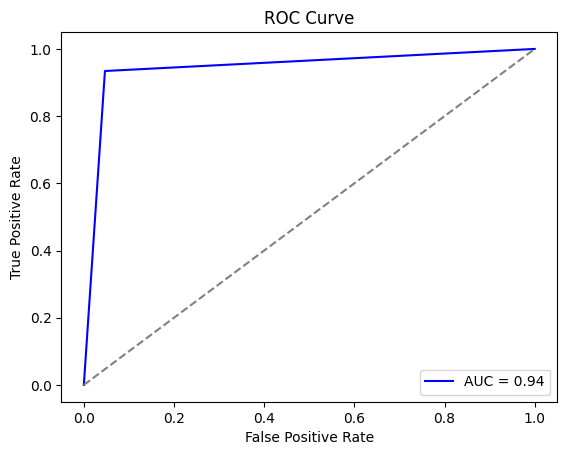

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(test_labels, y_pred)
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc_roc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import morphological_chan_vese
from skimage.filters import gaussian
from skimage import exposure
from skimage.draw import disk

def process_batch(preprocessed_images, max_iterations=100):
    segmented_images = []

    for idx, img in enumerate(preprocessed_images):
        if len(img.shape) > 2:
            img = img.mean(axis=2)  # Convert to grayscale

        # Enhance contrast
        img = exposure.equalize_hist(img)

        # Apply Gaussian blur
        #img = gaussian(img, sigma=1)

        # Create an initial level set (e.g., a small circle in the center)
        initial_level_set = np.zeros(img.shape, dtype=np.bool_)
        rr, cc = disk((img.shape[0] // 2, img.shape[1] // 2), radius=80)
        initial_level_set[rr, cc] = True

        results=[]
        def store_levelset(levelset):
            # Store the levelset after each iteration (for visualization or inspection purposes)
            results.append(levelset.copy())

        # Perform morphological Chan-Vese segmentation
        morphological_chan_vese(img, num_iter=max_iterations,init_level_set=initial_level_set, lambda1=1, lambda2=1, iter_callback=store_levelset)

        # Store the final levelset
                # Store the final levelset
        final_segmentation = results[-1]

        # Expand dimensions to (H, W, 1) to signify grayscale
        final_segmentation = np.expand_dims(final_segmentation, axis=-1)

        segmented_images.append(final_segmentation)

        # Visualization
        # fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        # fig.suptitle(f"Segmentation Process for Image {idx+1}")

        # # Show original image
        # axes[0].imshow(img, cmap='gray')
        # axes[0].set_title("Original Image")
        # axes[0].axis("off")

        # # Show segmentation at different iterations
        # # for i in range(max_iterations):
        # #     axes[i + 1].imshow(results[i], cmap='gray')
        # #     #axes[i + 1].set_title(f"Iteration {i+1}")
        # #     axes[i + 1].axis("off")
        # axes[1].imshow(results[max_iterations], cmap='gray')
        # axes[1].axis("off")
        # plt.show()
        

    return np.array(segmented_images)


In [ ]:
segmented_images= process_batch(train_data)

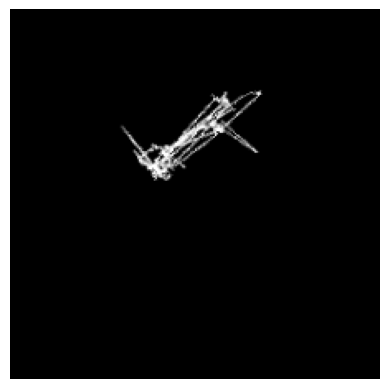

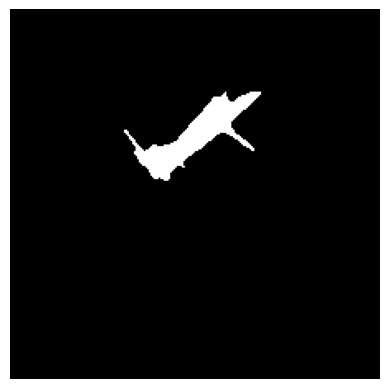

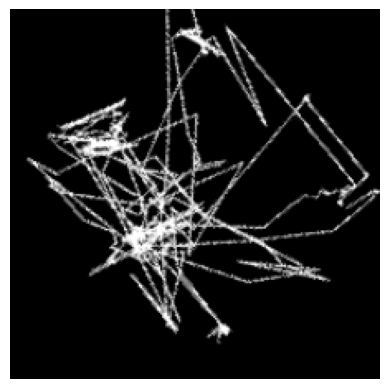

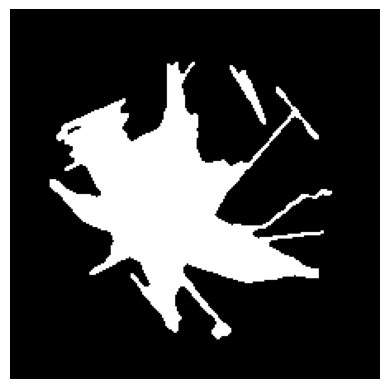

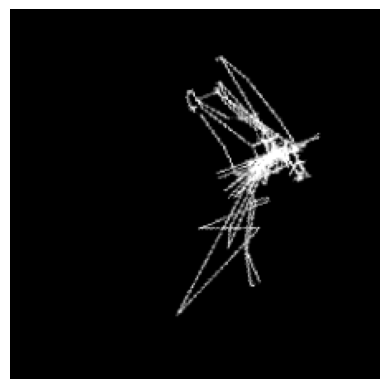

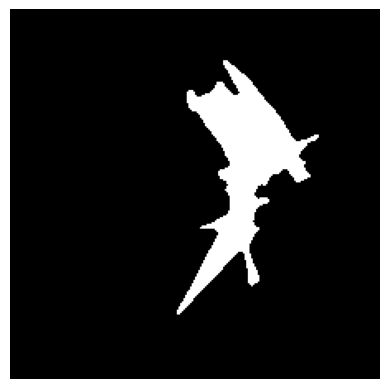

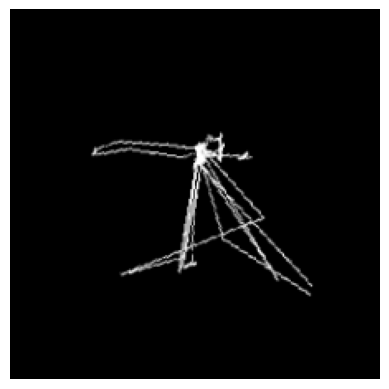

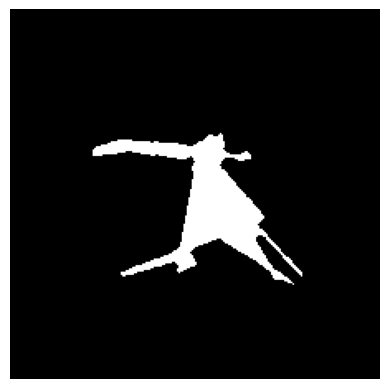

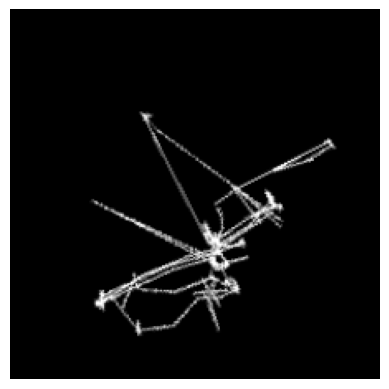

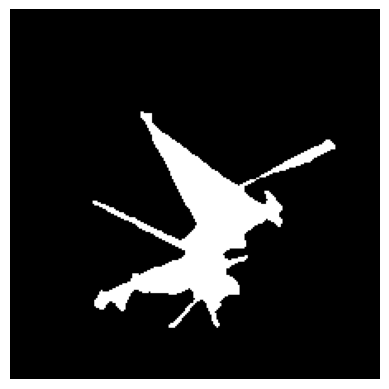

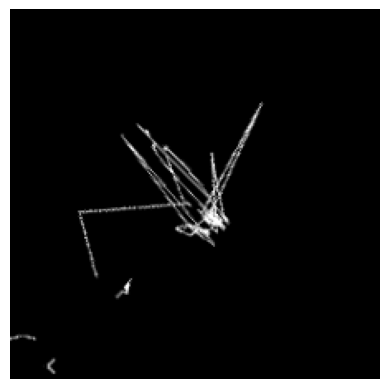

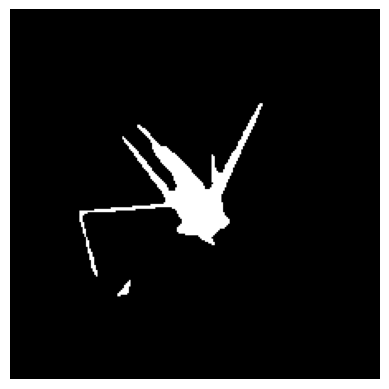

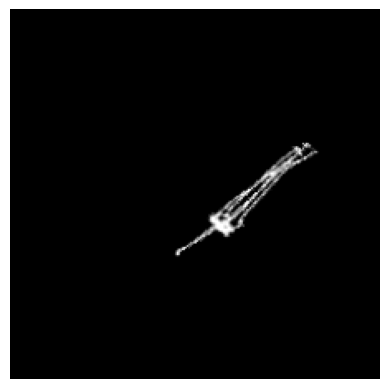

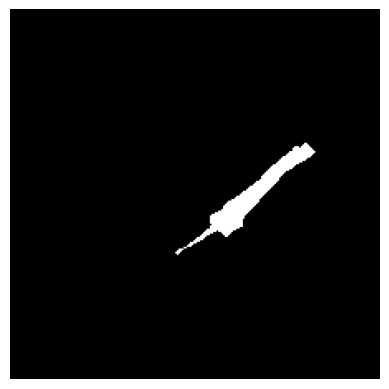

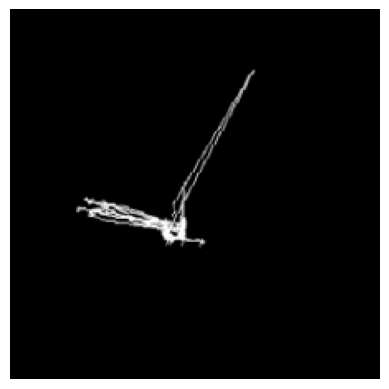

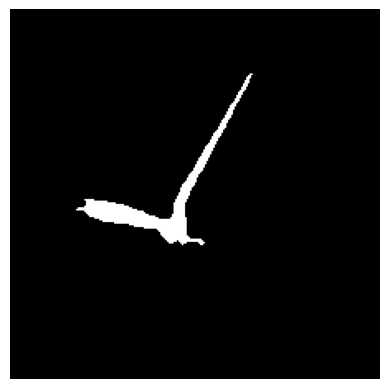

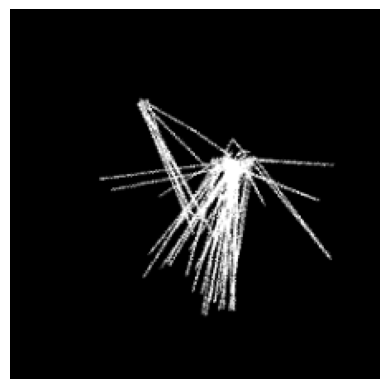

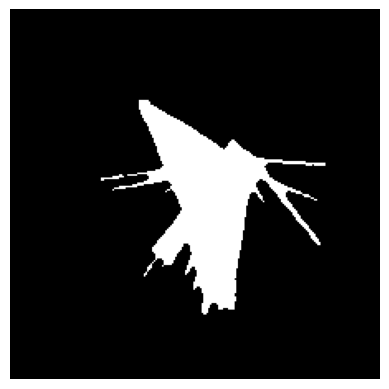

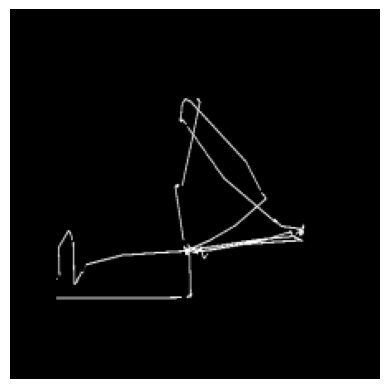

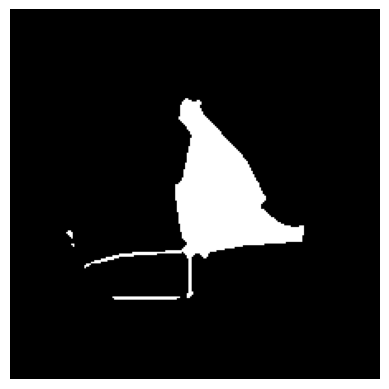

In [ ]:
for i in range(10):
    show_image(train_data[i])
    show_image(segmented_images[i])

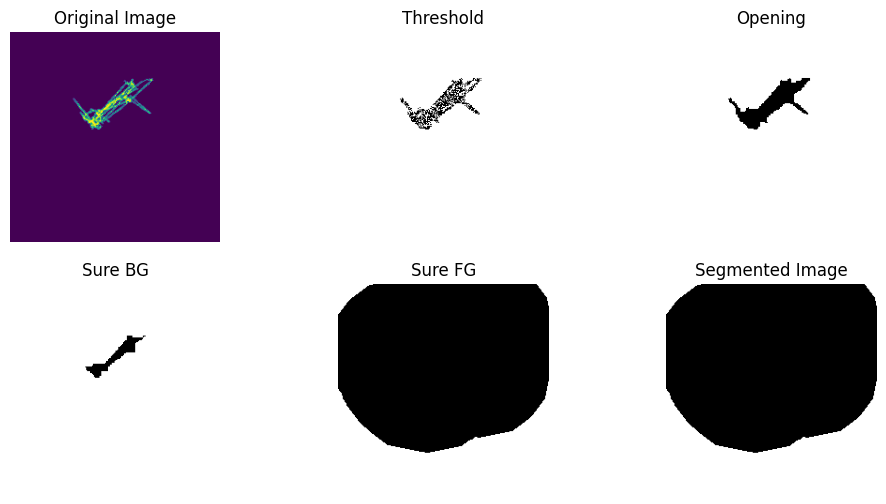

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
image = train_data[0]
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

gray= train_data[0]

gray = (gray * 255).astype(np.uint8)  # Scale from float (0 to 1) to uint8 (0 to 255)


# Apply binary thresholding
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Define kernel
kernel = np.ones((3,3), np.uint8)

# Noise removal (Opening)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Sure background (Dilation)
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Sure foreground (Distance Transform & Thresholding)
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)

# Unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Find connected components (segmentation)
num_labels, labels = cv2.connectedComponents(sure_fg)

# Colorize the segmented components
segmented = np.zeros_like(image, dtype=np.uint8)
for i in range(1, num_labels):  # Skip background (0)
    segmented[labels == i] = 255  # Assign white to objects

# Display Results
titles = ['Original Image', 'Threshold', 'Opening', 'Sure BG', 'Sure FG', 'Segmented Image']
images = [image, thresh, opening, sure_bg, sure_fg, segmented]

plt.figure(figsize=(12,6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i], cmap='gray' if i > 0 else None)
    plt.title(titles[i])
    plt.axis('off')
plt.show()


<h2>PCA</h2>

In [ ]:
from sklearn.preprocessing import StandardScaler

def apply_pca(data, labels, n_components=50):
    """
    Apply PCA to reduce the dimensionality of flattened image data.
    Args:
        data (np.array): Flattened image data of shape (n_samples, height * width).
        labels (np.array): Corresponding labels of shape (n_samples,).
        n_components (int): Number of principal components to keep.
    Returns:
        np.array, np.array, PCA: Transformed data, labels, and PCA model.
    """
    data = data.reshape(data.shape[0], -1)
    # Ensure the data is 2D (flattened images)
    # if data.ndim == 3 and data.shape[-1] == 1:  # Handle (n_samples, height, 1)
    #     data = np.squeeze(data, axis=-1)

    if data.ndim != 2:
        raise ValueError(f"Expected data to have 2 dimensions (n_samples, features), got {data.shape}.")

    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Initialize PCA and fit it on the flattened data
    pca = PCA(n_components=n_components)
    data_pca = pca.fit_transform(data_scaled)

    # Plot cumulative explained variance
    plt.figure(figsize=(8, 5))
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("Explained Variance by Principal Components")
    plt.grid()
    plt.show()

    return data_pca, labels, pca, scaler


In [ ]:
gc.collect()

3183

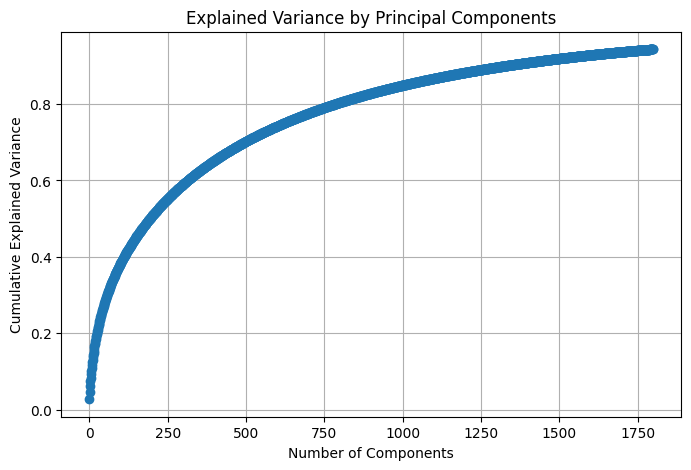

In [ ]:
with tf.device('/CPU:0'):
    train_data_pca, train_labels_pca, pca_model, scaler = apply_pca(train_data, train_labels, n_components=1800)

In [ ]:
svm = RandomForestClassifier(random_state=42)

In [ ]:
train_labels_pca = np.argmax(train_labels_pca, axis=1)

In [ ]:
svm.fit(train_data_pca, train_labels_pca)

RandomForestClassifier(random_state=42)

In [ ]:
if test_data.ndim >= 2:  # If it's 3D or 4D (images), reshape to 2D
    X_test = test_data.reshape(test_data.shape[0], -1)

In [ ]:
test_data_pca= pca_model.transform(X_test)

In [ ]:
y_pred_svm = svm.predict(test_data_pca)

In [ ]:
test_labels=np.argmax(test_labels,axis=1)

In [ ]:
accuracy_score(y_pred_svm, test_labels)

0.5838870431893688

In [ ]:
from tensorflow.keras.layers import BatchNormalization
n_components=1800

def create_model_pca(input_shape, n_classes):
    model = Sequential([
    #    Dense(64, activation='relu', input_shape=(n_components,), kernel_regularizer=l2(0.02)),
    #    BatchNormalization(),
    #     Dropout(0.3),  # Helps prevent overfitting
    #     Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    #     BatchNormalization(),
    #    Dropout(0.5),
        Dense(2, activation='softmax')  # Assuming 2 classes
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  #loss='binary_focal_crossentropy',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Initialize model
model_pca = create_model_pca(input_shape=(n_components,), n_classes=2)

# Display model summary
model_pca.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                115264    
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 32)               

In [ ]:
validation_data.shape

(963, 50176)

In [ ]:
validation_data = validation_data.reshape(validation_data.shape[0], -1)

In [ ]:
val_data_pca=pca_model.transform(validation_data)

In [ ]:
max_cars_score = 60
train_metadata = tf.cast(train_metadata, dtype=tf.float32) / max_cars_score  # Normalize to [0, 1]

train_metadata = tf.constant(1, dtype=float) + train_metadata

In [ ]:
reset_weights(model_pca)

NameError: name 'reset_weights' is not defined

In [ ]:
history_pca = model_pca.fit(train_data_pca, train_labels_pca, batch_size=batch_size, epochs=50,callbacks=[early_stopping, reduce_lr],
                            validation_data=(val_data_pca, validation_labels),
                            #class_weight={0: 0.8, 1: 1.2}, 
                            sample_weight=train_metadata
                            )

Epoch 1/50
241/241 [==============================] - 2s 6ms/step - loss: 2.6004 - accuracy: 0.7055 - lr: 2.0000e-04
Epoch 2/50
241/241 [==============================] - 1s 6ms/step - loss: 2.2552 - accuracy: 0.7283 - lr: 2.0000e-04
Epoch 3/50
241/241 [==============================] - 1s 6ms/step - loss: 1.9911 - accuracy: 0.7413 - lr: 2.0000e-04
Epoch 4/50
241/241 [==============================] - 1s 6ms/step - loss: 1.7611 - accuracy: 0.7686 - lr: 2.0000e-04
Epoch 5/50
241/241 [==============================] - 1s 6ms/step - loss: 1.5729 - accuracy: 0.7784 - lr: 2.0000e-04
Epoch 6/50
241/241 [==============================] - 1s 6ms/step - loss: 1.3987 - accuracy: 0.8034 - lr: 2.0000e-04
Epoch 7/50
241/241 [==============================] - 1s 6ms/step - loss: 1.2586 - accuracy: 0.8203 - lr: 2.0000e-04
Epoch 8/50
241/241 [==============================] - 1s 6ms/step - loss: 1.1496 - accuracy: 0.8306 - lr: 2.0000e-04
Epoch 9/50
241/241 [==============================] - 1s 6ms/ste

In [ ]:
test_data = test_data.reshape(test_data.shape[0], -1)

In [ ]:
test_data_pca=pca_model.transform(test_data)

In [ ]:
y_pred_pca = model_pca.predict(test_data_pca)

38/38 [==============================] - 0s 2ms/step


In [ ]:
test_labels, y_pred_pca

(array([[1., 0.],
        [0., 1.],
        [1., 0.],
        ...,
        [0., 1.],
        [1., 0.],
        [1., 0.]]),
 array([[0.0000000e+00, 1.0000000e+00],
        [0.0000000e+00, 1.0000000e+00],
        [0.0000000e+00, 1.0000000e+00],
        ...,
        [0.0000000e+00, 1.0000000e+00],
        [1.5893009e-24, 1.0000000e+00],
        [2.7316228e-08, 1.0000000e+00]], dtype=float32))

In [ ]:
accuracy_score(test_labels, y_pred_pca)

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

<h2> voter </h2>

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
#from catboost import CatBoostClassifier

from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import classification_report


In [ ]:
def focal_loss(gamma=2.0, alpha=0.25):
    """
    Custom focal loss function for XGBoost.
    """
    def focal_loss_grad_hess(preds, dtrain):
        """
        Compute the gradient and hessian of focal loss with sample weights.
        """
        labels = dtrain.get_label()
        sample_weight = dtrain.get_weight()  # Get sample weights

        preds = 1 / (1 + np.exp(-preds))  # Sigmoid transformation

        # Compute focal loss gradient and hessian
        p_t = np.where(labels == 1, preds, 1 - preds)
        grad = alpha * (1 - p_t) ** gamma * (preds - labels)
        hess = alpha * (1 - p_t) ** gamma * preds * (1 - preds) * (gamma * (1 - p_t) + 1)

        # Apply sample weights if available
        if sample_weight.size > 0:
            grad *= sample_weight
            hess *= sample_weight

        return grad, hess
    
    return focal_loss_grad_hess

# Define custom objective function for XGBoost
def xgb_focal_loss(y_pred, dtrain, sample_weight):
    grad, hess = focal_loss(gamma=2.0, alpha=0.25)(y_pred, dtrain)
    return grad, hess

In [ ]:
estimator = []
# estimator.append(('DecisionTreeClassifier', DecisionTreeClassifier(criterion='gini', max_features='log2',
#                                                                    random_state=42)))
#estimator.append(('LogisticRegression', LogisticRegression(solver ='lbfgs', multi_class ='multinomial', max_iter = 200)))
# estimator.append(('KNN', KNeighborsClassifier(n_neighbors=10, weights='distance') ))
# estimator.append(('ExtraTreesClassifier', ExtraTreesClassifier(random_state=42,criterion="log_loss" , max_depth=10,
#                                                                max_features='log2',# class_weight=class_weight_dict,
#                                                                 n_estimators=2000, min_samples_leaf=10) ))
# estimator.append(('RandomForest', RandomForestClassifier(random_state=42, n_estimators=500#,min_samples_leaf= 2, min_samples_split= 50
#                                                          ) ))
#estimator.append(('SVC', SVC(random_state=42, probability=True)))
#estimator.append(('AdaBoostClassifier', AdaBoostClassifier(random_state=42, n_estimators=149, algorithm='SAMME', learning_rate=0.5) ))
# estimator.append(('GradientBoostingClassifier', GradientBoostingClassifier(loss='log_loss',
#                                                                            min_samples_leaf=5, n_estimators=414,
#                                                                             learning_rate=0.01, criterion='squared_error' )))
#estimator.append(('BaggingClassifier', BaggingClassifier(estimator=e, n_estimators=10, random_state=42)))
estimator.append(('XGBClassifier', XGBClassifier(
    objective=xgb_focal_loss,  # Use custom focal loss function
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    eval_metric="logloss",
    use_label_encoder=False)))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier


# Create the Voting Classifier
VC_hard = VotingClassifier(estimators=estimator, voting='hard')


# Fit the model
#VC_hard.fit(X_train, train_labels_1d)  # Use 1D labels directly


In [ ]:
if train_data.ndim >= 2:  # If it's 3D or 4D (images), reshape to 2D
    X_train = train_data.reshape(train_data.shape[0], -1)

if test_data.ndim >= 2:  # If it's 3D or 4D (images), reshape to 2D
    X_test = test_data.reshape(test_data.shape[0], -1)

In [ ]:
y_train = np.argmax(train_labels, axis=1)

y_test = np.argmax(test_labels, axis=1)

In [ ]:
from sklearn.metrics import mean_squared_error, log_loss

ada= GradientBoostingClassifier(loss='log_loss',
                                min_samples_leaf=5, n_estimators=500,
                                learning_rate=0.01, criterion='squared_error').fit(X_train, y_train, train_metadata)

errors = [ log_loss(y_test, preds) for preds in ada.staged_predict(X_test)]

optimal_num_estimators = np.argmin(errors) + 1

In [ ]:
optimal_num_estimators

414

In [ ]:
train_metadata

<tf.Tensor: shape=(3850,), dtype=float32, numpy=
array([1.45     , 1.575    , 1.5166667, ..., 1.       , 1.45     ,
       1.4416666], dtype=float32)>

In [ ]:
import numpy as np
import xgboost as xgb

# Define the focal loss function
def focal_loss(alpha=0.25, gamma=2.0):
    """
    Custom focal loss function for XGBoost.
    Returns the gradient and hessian required for XGBoost optimization.
    """
    def loss(preds, dtrain):
        # Get the labels and sample weights
        labels = dtrain.get_label()
        sample_weights = dtrain.get_weight()  # Retrieve sample weights (metadata)

        # Number of classes
        num_classes = preds.shape[1]

        # Convert predictions to probabilities using softmax
        preds = np.exp(preds - np.max(preds, axis=1, keepdims=True))  # Prevent overflow
        preds /= np.sum(preds, axis=1, keepdims=True)  # Normalize to get probabilities

        # One-hot encoding for labels
        labels_onehot = np.eye(num_classes)[labels.astype(int)]

        # Compute the focal loss components
        pt = np.sum(labels_onehot * preds, axis=1)  # True class probabilities
        log_pt = np.log(pt + 1e-8)  # Log probabilities for numerical stability

        weight = alpha * (1 - pt) ** gamma  # Focal loss weight

        # Compute gradient (first derivative)
        grad = weight * (preds - labels_onehot)

        # Compute hessian (second derivative)
        hess = weight * preds * (1 - preds) * (gamma * (1 - pt) + 1)

        # Apply sample weights (metadata importance) to the loss
        grad = grad * sample_weights[:, np.newaxis]  # Element-wise multiplication with sample weights
        hess = hess * sample_weights[:, np.newaxis]  # Element-wise multiplication with sample weights

        # Flatten the gradients and hessians before returning
        return grad.flatten(), hess.flatten()

    return loss

# Create the DMatrix from your training data, including weights
train_dmatrix = xgb.DMatrix(X_train, label=y_train, weight=train_metadata)

# Create the XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    objective=focal_loss(alpha=0.25, gamma=2.0),  # Custom focal loss function
    eval_metric="mlogloss",
    num_class=3  # Adjust based on the number of classes
)

# Train the model with the DMatrix
xgb_clf.fit(X_train, y_train, sample_weight=train_metadata)  # Pass sample weights here

# Make predictions
y_pred = xgb_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
import numpy as np
import xgboost as xgb

# Define the focal loss function
def focal_loss(alpha=0.25, gamma=2.0):
    """
    Custom focal loss function for XGBoost.
    Returns the gradient and hessian required for XGBoost optimization.
    """
    def loss(preds, dtrain):
        # Get the labels and sample weights
        labels = dtrain.get_label()
        sample_weights = dtrain.get_weight()  # Retrieve sample weights (metadata)

        # Number of classes
        num_classes = 2

        # Convert predictions to probabilities using softmax
        preds = np.exp(preds - np.max(preds, axis=1, keepdims=True))  # Prevent overflow
        preds /= np.sum(preds, axis=1, keepdims=True)  # Normalize to get probabilities

        # One-hot encoding for labels
        labels_onehot = np.eye(num_classes)[labels.astype(int)]

        # Compute the focal loss components
        pt = np.sum(labels_onehot * preds, axis=1)  # True class probabilities
        log_pt = np.log(pt + 1e-8)  # Log probabilities for numerical stability

        weight = alpha * (1 - pt) ** gamma  # Focal loss weight

        # Compute gradient (first derivative)
        grad = weight * (preds - labels_onehot)

        # Compute hessian (second derivative)
        hess = weight * preds * (1 - preds) * (gamma * (1 - pt) + 1)

        # Apply sample weights (metadata importance) to the loss
        grad = grad * sample_weights[:, np.newaxis]  # Element-wise multiplication with sample weights
        hess = hess * sample_weights[:, np.newaxis]  # Element-wise multiplication with sample weights

        # Flatten the gradients and hessians before returning
        return grad.flatten(), hess.flatten()

    return loss

# Create the DMatrix from your training data, including weights
train_dmatrix = xgb.DMatrix(X_train, label=y_train, weight=train_metadata)

# Create the XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    objective=focal_loss(alpha=0.25, gamma=2.0),  # Custom focal loss function
    eval_metric="mlogloss",
    num_class=2  # Adjust based on the number of classes
)

# Train the model with the DMatrix
xgb_clf.fit(X_train, y_train, sample_weight=train_metadata)  # Pass sample weights here

# Make predictions
y_pred = xgb_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")


ValueError: Custom objective doesn't have the `sample_weight` parameter while sample_weight is used.

In [ ]:
from sklearn.metrics import accuracy_score

for name, model in VC_hard.estimators:
    model.fit(X_train, y_train,
              sample_weight=train_metadata)
    y_pred = model.predict(X_test)
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred)}")

c:\Users\Alex\miniconda3\envs\asdlicenta\lib\site-packages\xgboost\core.py:158: UserWarning: [23:25:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


AttributeError: 'numpy.ndarray' object has no attribute 'get_label'

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
#VC_hard = VotingClassifier(estimators = estimator, voting ='hard')

VC_hard.fit(X_train, train_labels)
y_pred = VC_hard.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

<h1> googlelenet </h1>

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def google_categorical_focal_loss(gamma=1.0, alpha=0.9):
    def focal_loss(y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)

        # Avoid log(0) errors
        epsilon = 1e-8  # More stable than K.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

        # Compute cross-entropy loss
        cross_entropy = -y_true * tf.math.log(y_pred)

        # Compute focal loss factor
        weight = alpha * y_true * tf.pow(1 - y_pred, gamma)

        # Apply focal loss
        loss = weight * cross_entropy
        loss = tf.reduce_sum(loss, axis=1)

        # Apply sample weights if provided
        if sample_weight is not None:
            loss *= sample_weight

        return loss

    return focal_loss


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from focal_loss import BinaryFocalLoss, SparseCategoricalFocalLoss

def create_googlenet_model(num_classes=2):
    # Load GoogleNet (InceptionV3) pretrained on ImageNet
    googlenet_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze most layers, fine-tune last 10 layers
    googlenet_base.trainable = False
    for layer in googlenet_base.layers[-10:]:
        layer.trainable = True

    # Input layer
    image_input = Input(shape=(224, 224, 3), name='image_input')

    # Feature extraction
    x = googlenet_base(image_input, training=False)
    x = GlobalAveragePooling2D()(x)  # Convert feature maps to vector

    # Fully connected layers
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Output layer (Binary or Multi-class classification)
    output = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=image_input, outputs=output)

    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.0005), 
                  #loss=categorical_focal_loss(),
                  #loss='categorical_crossentropy',
                  #loss=FocalLoss(),
                  loss=google_categorical_focal_loss(),
                  metrics=['accuracy'])

    return model

In [ ]:
model_google = create_googlenet_model(num_classes=2)

In [ ]:
reset_weights(model_google)

In [ ]:
train_labels = np.argmax(train_labels, axis=-1)
validation_labels = np.argmax(validation_labels, axis=-1)

In [ ]:
gc.collect()

11644

In [ ]:
with tf.device('/CPU:0'):
    history = model_google.fit(
        train_data,
        train_labels,
        epochs=15,
        sample_weight=train_metadata,
        validation_data=(validation_data, validation_labels),
        callbacks=[early_stopping, reduce_lr],
        batch_size=32
    )

Epoch 1/15
121/121 [==============================] - 150s 1s/step - loss: 1.4292 - accuracy: 0.5868 - val_loss: 0.2916 - val_accuracy: 0.6137 - lr: 5.0000e-04
Epoch 2/15
121/121 [==============================] - 153s 1s/step - loss: 0.3405 - accuracy: 0.6473 - val_loss: 0.2872 - val_accuracy: 0.6968 - lr: 5.0000e-04
Epoch 3/15
121/121 [==============================] - 160s 1s/step - loss: 0.3419 - accuracy: 0.6977 - val_loss: 0.2972 - val_accuracy: 0.7113 - lr: 5.0000e-04
Epoch 4/15
121/121 [==============================] - 148s 1s/step - loss: 0.3354 - accuracy: 0.7101 - val_loss: 0.2815 - val_accuracy: 0.6906 - lr: 5.0000e-04
Epoch 5/15
121/121 [==============================] - 146s 1s/step - loss: 0.3210 - accuracy: 0.7301 - val_loss: 0.2748 - val_accuracy: 0.7082 - lr: 5.0000e-04
Epoch 6/15
121/121 [==============================] - 150s 1s/step - loss: 0.3324 - accuracy: 0.7065 - val_loss: 0.2698 - val_accuracy: 0.7238 - lr: 5.0000e-04
Epoch 7/15
121/121 [====================

In [ ]:
y_pred_google=model_google.predict(test_data)

38/38 [==============================] - 7s 127ms/step


In [ ]:
y_true = np.argmax(test_labels, axis=1)

y_pred_google = np.argmax(y_pred_google, axis=1)

In [ ]:
accuracy_score(y_pred_google, y_true)

0.7142857142857143

<h1>resnet</h1>

In [31]:
import torch
import torch.nn as nn
import torchvision.models as models

In [32]:
def create_model_resnet():
    base_model = models.resnet18(weights="DEFAULT")
    
    # Freeze all layers
    for param in base_model.parameters():
        param.requires_grad = False

    # Modify the fully connected layer
    num_ftrs = base_model.fc.in_features
    base_model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 2),  # Final classification layer (2 classes)
        nn.Softmax(dim=1)  # Softmax activation for multi-class classification
    )

    return base_model

In [55]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def resnet18(input_shape=(224, 224, 3), num_classes=2):
    inputs = layers.Input(shape=input_shape)
    
    # Initial Convolution Layer
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Maxpooling Layer
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)
    
    # Block 1
    x = resnet_block(x, 64, 2)
    
    # Block 2
    x = resnet_block(x, 128, 2, strides=2)
    
    # Block 3
    x = resnet_block(x, 256, 2, strides=2)
    
    # Block 4
    x = resnet_block(x, 512, 2, strides=2)
    
    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)
    
    # Fully connected Layer
    x = layers.Dense(num_classes, activation="softmax")(x)
    
    model = models.Model(inputs=inputs, outputs=x)
    
    return model

def resnet_block(x, filters, blocks, strides=1):
    # Identity shortcut (skip connection)
    shortcut = x
    
    # First convolution layer
    x = layers.Conv2D(filters, (3, 3), padding="same", strides=strides)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Second convolution layer
    x = layers.Conv2D(filters, (3, 3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    # Skip connection (if necessary, adjust shortcut size with a convolution)
    if strides != 1 or x.shape[-1] != shortcut.shape[-1]:
        shortcut = layers.Conv2D(filters, (1, 1), strides=strides, padding="same")(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    
    # Add the shortcut to the main path
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    
    return x

# Create the model
model_resnet18 = resnet18(input_shape=(224, 224, 3), num_classes=2)  # num_classes can be adjusted to your dataset

# Compile the model
model_resnet18.compile(optimizer='adam', loss=categorical_focal_loss(), metrics=['accuracy'])

# Summary of the model
model_resnet18.summary()


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_108 (Conv2D)            (None, 112, 112, 64  9472        ['input_10[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_108 (Batch  (None, 112, 112, 64  256        ['conv2d_108[0][0]']             
 Normalization)                 )                                                           

In [56]:
reset_weights(model_resnet18)

In [57]:
with tf.device('/CPU:0'):
    history_resnet = model_resnet18.fit(
        train_data, train_labels, 
        validation_data=(validation_data, validation_labels),
        epochs=15, 
        sample_weight=train_metadata,
        callbacks=[early_stopping, reduce_lr])

Epoch 1/15
121/121 [==============================] - 238s 2s/step - loss: 0.0509 - accuracy: 0.7101 - val_loss: 0.1918 - val_accuracy: 0.5722 - lr: 0.0010
Epoch 2/15
121/121 [==============================] - 221s 2s/step - loss: 0.0410 - accuracy: 0.7416 - val_loss: 0.0360 - val_accuracy: 0.7321 - lr: 0.0010
Epoch 3/15
121/121 [==============================] - 220s 2s/step - loss: 0.0397 - accuracy: 0.7545 - val_loss: 0.0381 - val_accuracy: 0.7487 - lr: 0.0010
Epoch 4/15
121/121 [==============================] - 221s 2s/step - loss: 0.0378 - accuracy: 0.7634 - val_loss: 0.0644 - val_accuracy: 0.6075 - lr: 0.0010
Epoch 5/15
121/121 [==============================] - 220s 2s/step - loss: 0.0376 - accuracy: 0.7675 - val_loss: 0.0696 - val_accuracy: 0.6428 - lr: 0.0010
Epoch 6/15
121/121 [==============================] - 220s 2s/step - loss: 0.0321 - accuracy: 0.8125 - val_loss: 0.0635 - val_accuracy: 0.4226 - lr: 2.0000e-04
Epoch 7/15
121/121 [==============================] - 219s 2

In [59]:
y_pred_resnet18 = model_resnet18.predict(test_data)

: 

In [ ]:
from sklearn.metrics import accuracy_score

# Convert probabilities to class labels
y_pred_resnet_labels = np.argmax(y_pred_resnet18, axis=1)  # Picks the highest probability index
#y_true_labels = np.argmax(test_labels, axis=1)  # Convert one-hot to labels

# Compute accuracy
acc = accuracy_score(test_labels, y_pred_resnet_labels)
print(f"Accuracy: {acc:.4f}")

In [36]:
model_resnet=create_model_resnet()

In [40]:
gc.collect()

3275

In [41]:
with tf.device('/CPU:0'):
    history_resnet = model_resnet.fit(
        train_data, train_labels, 
        validation_data=(validation_data, validation_labels),
        epochs=15, 
        sample_weight=train_metadata,
        callbacks=[early_stopping, reduce_lr])

AttributeError: 'ResNet' object has no attribute 'fit'

In [49]:
y_pred_resnet = model_resnet.predict(test_data)

38/38 [==============================] - 40s 609ms/step


In [55]:
from sklearn.metrics import accuracy_score

# Convert probabilities to class labels
y_pred_resnet_labels = np.argmax(y_pred_resnet, axis=1)  # Picks the highest probability index
#y_true_labels = np.argmax(test_labels, axis=1)  # Convert one-hot to labels

# Compute accuracy
acc = accuracy_score(test_labels, y_pred_resnet_labels)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.7857


In [37]:
# Adapted from https://github.com/pytorch/vision/blob/v0.4.0/torchvision/models/resnet.py
import math
from tensorflow import keras
from tensorflow.keras import layers

kaiming_normal = keras.initializers.VarianceScaling(scale=2.0, mode='fan_out', distribution='untruncated_normal')

def conv3x3(x, out_planes, stride=1, name=None):
    x = layers.ZeroPadding2D(padding=1, name=f'{name}_pad')(x)
    return layers.Conv2D(filters=out_planes, kernel_size=3, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=name)(x)

def basic_block(x, planes, stride=1, downsample=None, name=None):
    identity = x

    out = conv3x3(x, planes, stride=stride, name=f'{name}.conv1')
    out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn1')(out)
    out = layers.ReLU(name=f'{name}.relu1')(out)
    #out = layers.Dropout(0.3, name=f'{name}.dropout1')(out)  # Dropout after first activation

    out = conv3x3(out, planes, name=f'{name}.conv2')
    out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn2')(out)

    if downsample is not None:
        for layer in downsample:
            identity = layer(identity)

    out = layers.Add(name=f'{name}.add')([identity, out])
    out = layers.ReLU(name=f'{name}.relu2')(out)
    #out = layers.Dropout(0.3, name=f'{name}.dropout2')(out)  # Dropout after second activation

    return out

def make_layer(x, planes, blocks, stride=1, name=None):
    downsample = None
    inplanes = x.shape[3]
    if stride != 1 or inplanes != planes:
        downsample = [
            layers.Conv2D(filters=planes, kernel_size=1, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=f'{name}.0.downsample.0'),
            layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.0.downsample.1'),
        ]

    x = basic_block(x, planes, stride, downsample, name=f'{name}.0')
    for i in range(1, blocks):
        x = basic_block(x, planes, name=f'{name}.{i}')

    return x

def resnet(x, blocks_per_layer, num_classes=1000):
    x = layers.ZeroPadding2D(padding=3, name='conv1_pad')(x)
    x = layers.Conv2D(filters=64, kernel_size=7, strides=2, use_bias=False, kernel_initializer=kaiming_normal, name='conv1')(x)
    x = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name='bn1')(x)
    x = layers.ReLU(name='relu1')(x)
    x = layers.ZeroPadding2D(padding=1, name='maxpool_pad')(x)
    x = layers.MaxPool2D(pool_size=3, strides=2, name='maxpool')(x)

    x = make_layer(x, 64, blocks_per_layer[0], name='layer1')
    x = make_layer(x, 128, blocks_per_layer[1], stride=2, name='layer2')
    x = make_layer(x, 256, blocks_per_layer[2], stride=2, name='layer3')
    #x = make_layer(x, 512, blocks_per_layer[3], stride=2, name='layer4')

    x = layers.GlobalAveragePooling2D(name='avgpool')(x)
    initializer = keras.initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512))
    x = layers.Dropout(0.2, name='dropout')(x)
    x = layers.Dense(units=num_classes, kernel_initializer=initializer, bias_initializer=initializer, name='fc')(x)

    return x

def resnet18(x, **kwargs):
    return resnet(x, [2, 2, 2, 2], **kwargs)

def resnet34(x, **kwargs):
    return resnet(x, [3, 4, 6, 3], **kwargs)

In [48]:
import tensorflow as tf
from tensorflow import keras

# Define input shape (e.g., 224x224 RGB images)
input_shape = (224, 224, 3)
num_classes = 2  # Adjust based on your dataset

# Create input tensor
input_tensor = keras.Input(shape=input_shape)

# Get the ResNet18 output
output_tensor = resnet18(input_tensor, num_classes=num_classes)

# Create the model
model_resnet18_1 = keras.Model(inputs=input_tensor, outputs=output_tensor)

# Print model summary
model_resnet18_1.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9408        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
# Compile the model
model_resnet18_1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    # loss=categorical_focal_loss(),
    metrics=['accuracy']
)


In [53]:
gc.collect()

9044

In [54]:
with tf.device('/CPU:0'):
    history_resnet = model_resnet18_1.fit(
        train_data, train_labels, 
        validation_data=(validation_data, validation_labels),
        epochs=15, 
        sample_weight=train_metadata,
        callbacks=[early_stopping, reduce_lr])

Epoch 1/15
121/121 [==============================] - 319s 3s/step - loss: 0.6486 - accuracy: 0.7382 - val_loss: 0.6869 - val_accuracy: 0.6563 - lr: 0.0010
Epoch 2/15
121/121 [==============================] - 316s 3s/step - loss: 0.6310 - accuracy: 0.7488 - val_loss: 0.5161 - val_accuracy: 0.7414 - lr: 0.0010
Epoch 3/15
121/121 [==============================] - 318s 3s/step - loss: 0.6186 - accuracy: 0.7519 - val_loss: 0.6949 - val_accuracy: 0.6625 - lr: 0.0010
Epoch 4/15
121/121 [==============================] - 316s 3s/step - loss: 0.6163 - accuracy: 0.7600 - val_loss: 0.5307 - val_accuracy: 0.7456 - lr: 0.0010
Epoch 5/15
121/121 [==============================] - 314s 3s/step - loss: 0.6044 - accuracy: 0.7603 - val_loss: 0.4951 - val_accuracy: 0.7518 - lr: 0.0010
Epoch 6/15
121/121 [==============================] - 339s 3s/step - loss: 0.5948 - accuracy: 0.7608 - val_loss: 0.6223 - val_accuracy: 0.6812 - lr: 0.0010
Epoch 7/15
121/121 [==============================] - 346s 3s/st

In [55]:
y_pred_resnet18_1 = model_resnet18_1.predict(test_data)

38/38 [==============================] - 9s 42ms/step


In [57]:
from sklearn.metrics import accuracy_score

# Convert probabilities to class labels
y_pred_resnet_labels = np.argmax(y_pred_resnet18_1, axis=1)  # Picks the highest probability index
y_true_labels = np.argmax(test_labels, axis=1)  # Convert one-hot to labels

# Compute accuracy
acc = accuracy_score(y_true_labels, y_pred_resnet_labels)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.7492
